## Introduction  

The datasets contains transactions made by credit cards in **September 2013** by european cardholders. This dataset presents transactions that occurred in two days, where we have **492 frauds** out of **284,807 transactions**. The dataset is **highly unbalanced**, the **positive class (frauds)** account for **0.172%** of all transactions.  

It contains only numerical input variables which are the result of a **PCA transformation**.   

Due to confidentiality issues, there are not provided the original features and more background information about the data.  

* Features **V1**, **V2**, ... **V28** are the **principal components** obtained with **PCA**;  
* The only features which have not been transformed with PCA are **Time** and **Amount**. Feature **Time** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **Amount** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.   
* Feature **Class** is the response variable and it takes value **1** in case of fraud and **0** otherwise.  



## Load packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
import xgboost as xgb
from datetime import datetime 
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import plotly.graph_objs as go
import plotly.plotly as py
import itertools

from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv("creditcard.csv")

# Overview of data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

We can see that the data has 284807 rows and 31 columns

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


we see from above that the time is starting from a reference zero and all other timings are with respect to that reference

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Check missing data 

Let's check if there is any missing data.

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing data in the dataset.

Data imbalance

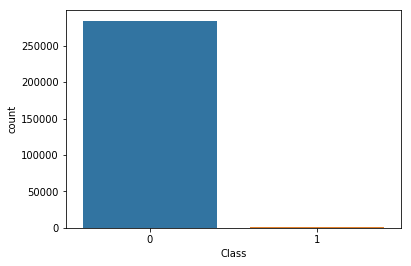

In [7]:
sns.countplot("Class",data=df)

In [8]:
normal_count = len(df[df["Class"]==0])
Fraud_count = len(df[df["Class"]==1])
Percentage_of_normal= normal_count/df.shape[0]
Percentage_of_Fraud= Fraud_count/df.shape[0]
print("percentage of fraud and normal is", Percentage_of_Fraud," and",Percentage_of_normal,"respectively" )



percentage of fraud and normal is 0.001727485630620034  and 0.9982725143693799 respectively


we can see that the dat ais highly imbalanced


## Data exploration

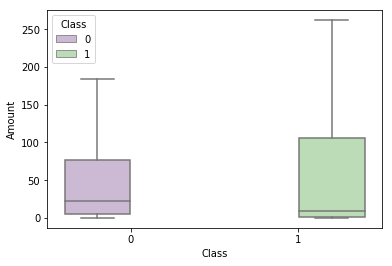

In [12]:
sns.boxplot(x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

The mean of normal transactions is more than the fraud transactions

Let's plot the fraudulent transactions (amount) against time. The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

## Features correlation

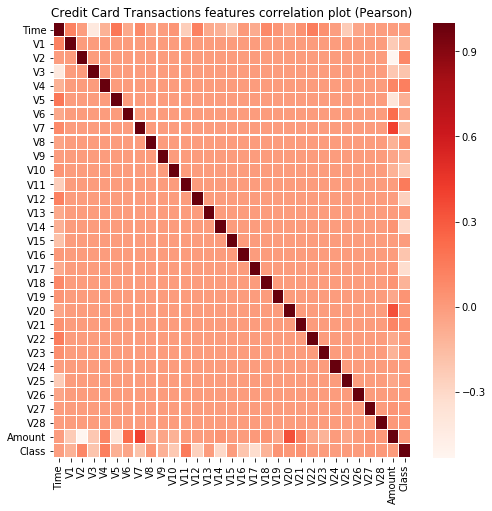

In [14]:
plt.figure(figsize = (8,8))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

It can be observed that:
There is no much notable correlation between featuresV1-V28.
But there is  correlation between Time and V3 and 
Amount correlation with V2,V5,V7 and V20 

In [52]:
y = df['Class']
X = df.drop(columns=['Class'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y, random_state=12)

In [59]:
smote = SMOTE(sampling_strategy='auto', random_state=12)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

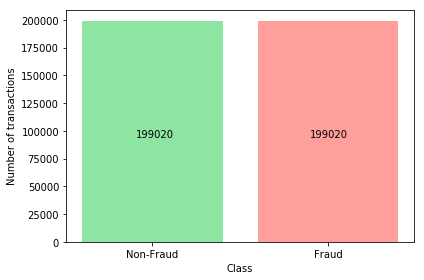

In [71]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_smote)[0], Counter(y_smote)[1]], color=['g','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_smote)[0]), (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_smote)[1]), (0.70, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [62]:
classifiers = []
classifiers.append(('Logistic Regression', LogisticRegression(random_state=12)))
classifiers.append(('Naive Bayes', GaussianNB()))
classifiers.append(('KNN', KNeighborsClassifier()))
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=12)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=12)))

Define functions and use them as below

In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
def feature_scaling(X, X_test=X_test):
    std_scale = StandardScaler().fit(X)
    X_std = std_scale.transform(X)
    X_test_std = std_scale.transform(X_test)
    return X_std, X_test_std

In [66]:
X_smote_std, X_test_smote_std = feature_scaling(X_smote)

In [67]:
def plot_CM_and_ROC_curve(classifier, X_train, y_train, X_test, y_test): 
    name = classifier[0]
    classifier = classifier[1]

    mean_fpr = np.linspace(0, 1, 100)
    class_names = ['Non-Fraud', 'Fraud']
    confusion_matrix_total = [[0, 0], [0, 0]]
    
    #Obtain probabilities for each class
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=1, color='b', label='ROC (AUC = %0.7f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - model: ' + name)
    plt.legend(loc="lower right")
    plt.show()
    
    #Store the confusion matrix result to plot a table later
    y_pred=classifier.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_total += cnf_matrix
    
    #Print precision and recall
    tn, fp = confusion_matrix_total.tolist()[0]
    fn, tp = confusion_matrix_total.tolist()[1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Accuracy = {:2.2f}%'.format(accuracy*100))
    print('Precision = {:2.2f}%'.format(precision*100))
    print('Recall = {:2.2f}%'.format(recall*100))
    
    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(confusion_matrix_total, classes=class_names, title='Confusion matrix - model: ' + name)
    plt.show()
             
             

C:\Users\chund\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



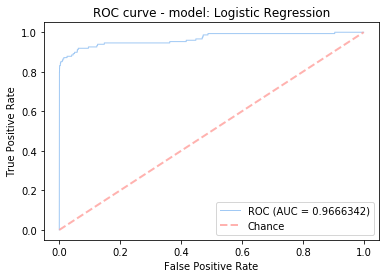

Accuracy = 99.14%
Precision = 14.95%
Recall = 85.14%


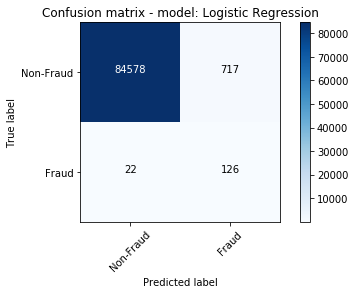

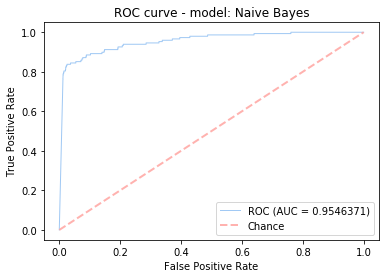

Accuracy = 97.69%
Precision = 5.91%
Recall = 82.43%


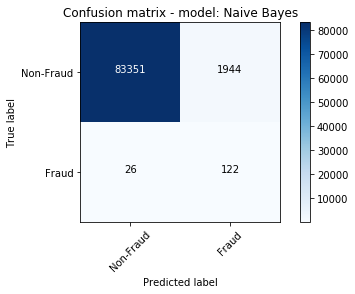

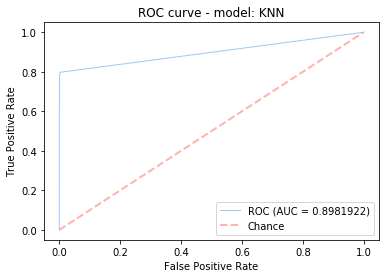

Accuracy = 99.82%
Precision = 48.13%
Recall = 78.38%


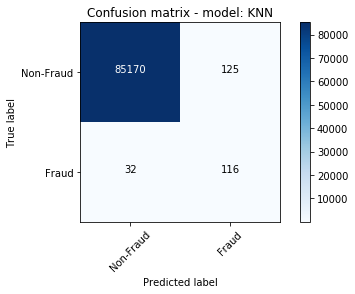

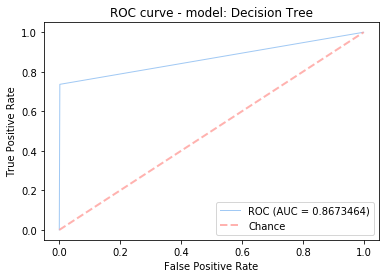

Accuracy = 99.78%
Precision = 41.60%
Recall = 73.65%


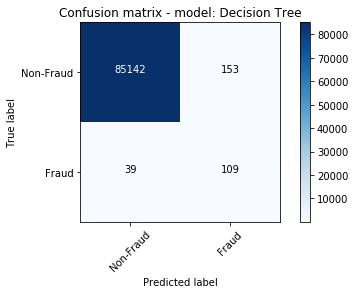

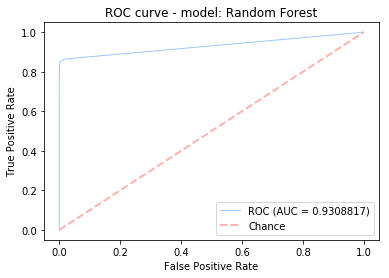

Accuracy = 99.94%
Precision = 84.06%
Recall = 78.38%


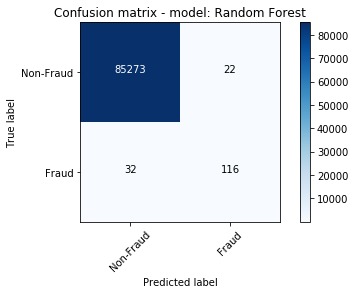

In [72]:
for clf in classifiers:
    plot_CM_and_ROC_curve(clf, X_smote_std, y_smote, X_test_smote_std, y_test)
    

Usually accuracy is a good metric for choosing a model, but here the data is highly imbalanced hence, even the worest model that classifies all transactions into good will also have 99.82 percent accuracry. But that does not mean it is a good one, this model can not predict the fradulent transaction, which is very important to the credit card company. hence we will be using Area Under Curve and Recall so as to choose the best model.

As we see that the recall value for Logistic Regression is good and also the Area Under Curve is 96.66 percentage. Hence for the given data we can say that Logistic Regression is a good model.